In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

READ IN WAVEFORMS

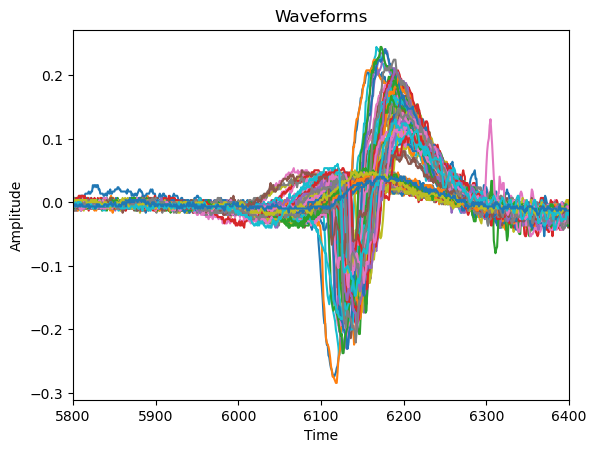

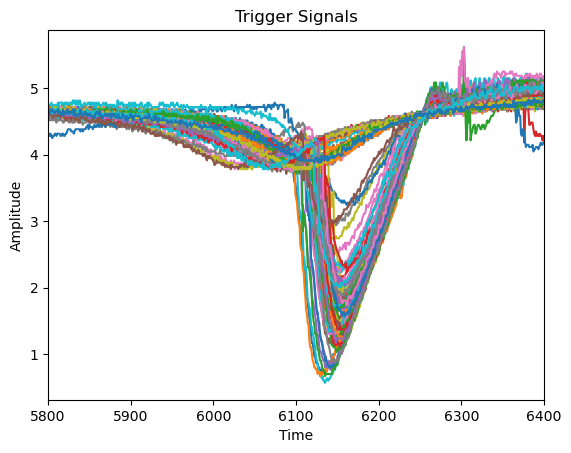

In [3]:
def read_data(filename, seg_len):
    filepath = "C:/Users/louis/OneDrive/Documents/University of Manchester/Physics/Year 4/MPhys/data/MPhys Sem 1 SiPM-Scintillation (KeySight Oscilloscope)/"
    data = np.genfromtxt(filepath + filename, delimiter=',', skip_header=3)
    n_segs = len(data) // seg_len

    waveforms = np.zeros((n_segs, seg_len, 3))
    for i in range(n_segs):
        waveforms[i] = data[i*seg_len:(i+1)*seg_len]

    trig_pos = np.zeros(n_segs)
    for i in range(n_segs):
        trig_pos[i] = np.argmin(waveforms[i, :, 1])

    waveform_windows = np.zeros((n_segs, 2000, 3))
    for i in range(n_segs):
        #print(trig_pos[i])
        if trig_pos[i] < 1000:
            waveform_windows[i, int(1000-trig_pos[i]):2000] = waveforms[i,0:int(trig_pos[i]+1000),:]
        elif trig_pos[i] > seg_len-1000:
            waveform_windows[i, int(2000-(seg_len-trig_pos[i])):2000] = waveforms[i,int(trig_pos[i]):seg_len,:]
        else: waveform_windows[i] = waveforms[i,int(trig_pos[i]-1000):int(trig_pos[i]+1000),:]

    for waveform in waveforms:
        plt.plot(waveform[:, 2])

    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.title("Waveforms")
    plt.xlim(5800,6400)
    plt.show()

    for waveform in waveforms:
        plt.plot(waveform[:, 1])

    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.title("Trigger Signals")
    plt.xlim(5800,6400)
    plt.show()

    return waveform_windows, n_segs

waveforms_55V_1200V_Ar_filter, n_segs_55V_1200V_Ar_filter = read_data("55V_1200V_Ar_filter.csv", 12500)

SUM WAVEFORMS, APPLY FILTER, DETERMINE ROI

In [4]:
def find_roi(waveforms, n_segs, plot=False):

    #waveforms_sum = np.sum(waveforms, axis=0)
    #savgol_filtered = savgol_filter(waveforms_sum[:, 2], 60, 9)
    #savgol_filtered_deriv = savgol_filter(waveforms_sum[:, 2], 60, 9, deriv=1)

    #turnover_point = np.argmin(np.abs(savgol_filtered_deriv[np.argmin(savgol_filtered_deriv):np.argmax(savgol_filtered_deriv)])) + np.argmin(savgol_filtered_deriv)
    #peak = np.argmax(savgol_filtered)
    #roi = [turnover_point, peak+3*(peak-turnover_point)]

    rois = np.zeros((n_segs, 2))

    for i in range(n_segs):
        peak = np.argmax(waveforms[i,:,2])
        rois[i,0] = np.argmin(waveforms[i,0:peak,2])
        rois[i,1] = np.argmin(waveforms[i,0:peak,2]) + 4*(peak - np.argmin(waveforms[i,0:peak,2]))
        if np.min(waveforms[i,int(rois[i,0]):int(rois[i,1]),2]) < np.min(waveforms[i,0:peak,2]): 
            rois[i,1] = np.argmin(waveforms[i,int(rois[i,0]):int(rois[i,1]),2])
        if rois[i,1] > 1999:
            rois[i,1] = 1999

    if plot==True:
        for i in range(n_segs):
            plt.plot(waveforms[i,:,2])
            plt.plot(rois[i,0], waveforms[i,int(rois[i,0]),2], "ro")
            plt.plot(rois[i,1], waveforms[i,int(rois[i,1]),2], "ro")
            plt.show()

    #plt.plot(waveforms_sum[:, 2], label="Summed Waveforms")
    #plt.plot(savgol_filtered, label="Savitzky-Golay Filtered")
    #plt.plot(savgol_filtered_deriv, label="Savitzky-Golay Filtered Derivative")
    #plt.plot(turnover_point, savgol_filtered[turnover_point], 'ro', label="Turnover Point")
    #plt.plot(peak, savgol_filtered[peak], 'ro', label="Peak")
    #plt.plot(roi[1], savgol_filtered[roi[1]], 'ro', label="ROI")
    #plt.xlabel("Time")
    #plt.ylabel("Amplitude")
    #plt.title("Summed Waveforms")
    #plt.legend()
    #plt.xlim(5800,7000)
    #plt.show()

    return rois

roi_55V_1200V_Ar_filter = find_roi(waveforms_55V_1200V_Ar_filter, n_segs_55V_1200V_Ar_filter)

INTEGRATE WAVEFORMS, PLOT HISTOGRAM

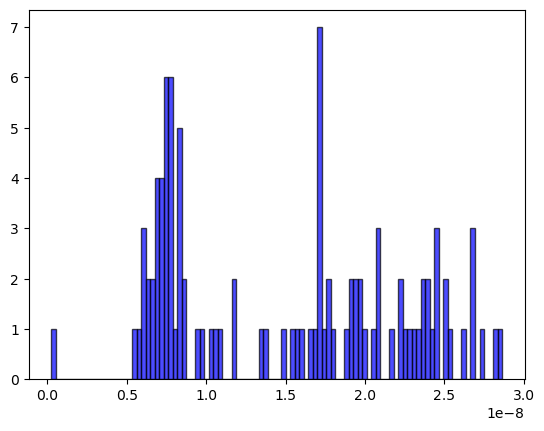

In [5]:
def integrate_waveforms(waveforms, n_segs, roi):
    areas = np.zeros(n_segs)

    for i in range(n_segs):
        area = np.zeros(np.abs(int(roi[i,1]-roi[i,0])))
        for j in range(np.abs(int(roi[i,1]-roi[i,0]))):
            pos = int(roi[i,0]+j)
            area[j] = (waveforms[i,pos+1,0]-waveforms[i, pos, 0])*np.sum(waveforms[i, pos:pos+1, 2])/2
            if area[j] < 0: area[j] = 0
            if np.isnan(area[j]) == True: area[j] = 0
        areas[i] = np.sum(area)

    hist = plt.hist(areas, bins=100, color='blue', edgecolor='black', alpha=0.7)

    mean = np.mean(areas)
    stdev = np.std(areas)

    return areas, hist, mean, stdev

areas_55V_1200V_Ar_filter, hist_55V_1200V_Ar_filter, mean_55V_1200V_Ar_filter, stdev_55V_1200V_Ar_filter = integrate_waveforms(waveforms_55V_1200V_Ar_filter, n_segs_55V_1200V_Ar_filter, roi_55V_1200V_Ar_filter)

CREATE HISTOGRAMS, FIND MEANS, STANDARD DEVIATIONS

1.4977836153951664e-08 7.294341580963623e-09


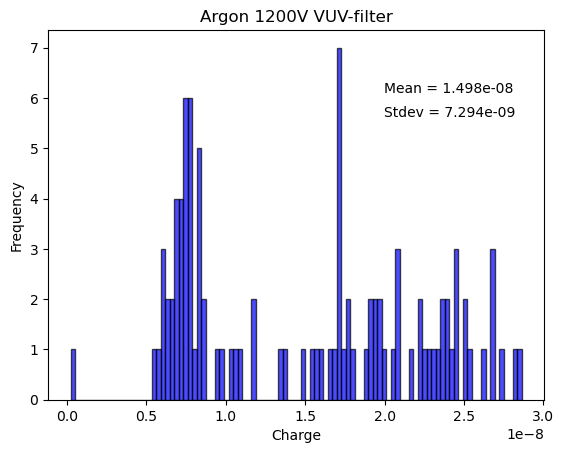

In [6]:
hist = plt.hist(areas_55V_1200V_Ar_filter, bins=100, color='blue', edgecolor='black', alpha=0.7)
plt.xlabel("Charge")
plt.ylabel("Frequency")
plt.title("Argon 1200V VUV-filter")
plt.annotate("Mean = {0:3.3e}".format(mean_55V_1200V_Ar_filter), (0.6, 0.75), xycoords='figure fraction')
plt.annotate("Stdev = {0:3.3e}".format(stdev_55V_1200V_Ar_filter), (0.6, 0.7), xycoords='figure fraction')
print(mean_55V_1200V_Ar_filter, stdev_55V_1200V_Ar_filter)

PLOT MEANS AGAINST VOLTAGES W/ S.D. ERRORS

RESULTS

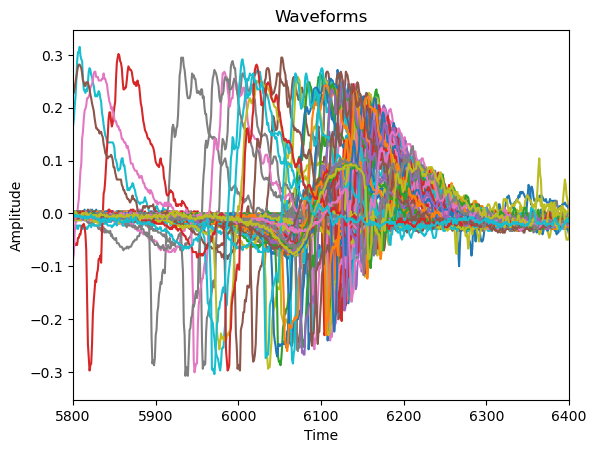

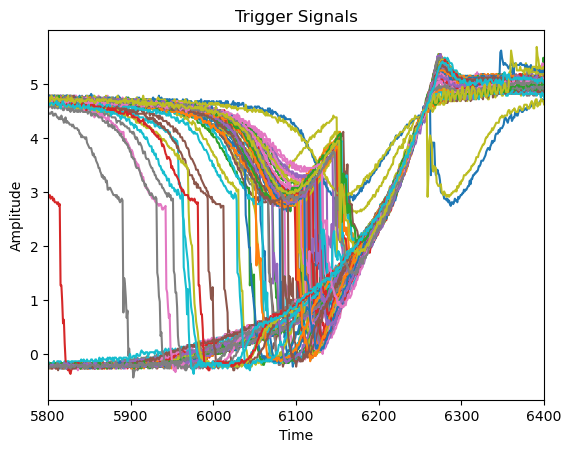

1.936450412651356e-08 8.933397614658956e-09


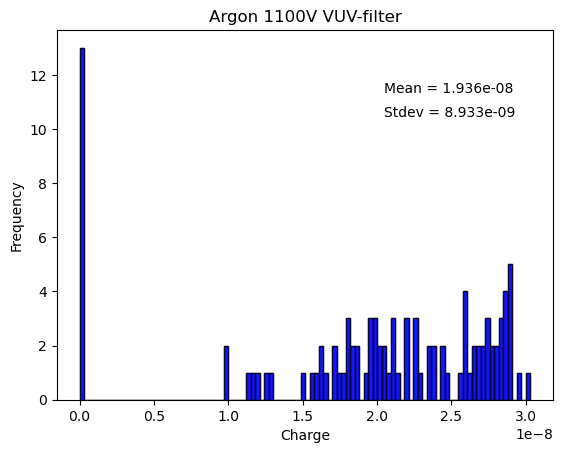

In [7]:
waveforms_55V_1100V_Ar_filter, n_segs_55V_1100V_Ar_filter = read_data("55V_1100V_Ar_filter.csv", 12500)
roi_55V_1100V_Ar_filter = find_roi(waveforms_55V_1100V_Ar_filter, n_segs_55V_1100V_Ar_filter)
areas_55V_1100V_Ar_filter, hist_55V_1100V_Ar_filter, mean_55V_1100V_Ar_filter, stdev_55V_1100V_Ar_filter  = integrate_waveforms(waveforms_55V_1100V_Ar_filter, n_segs_55V_1100V_Ar_filter, roi_55V_1100V_Ar_filter)
hist = plt.hist(areas_55V_1100V_Ar_filter, bins=100, color='blue', edgecolor='black', alpha=0.7)
plt.xlabel("Charge")
plt.ylabel("Frequency")
plt.title("Argon 1100V VUV-filter")
plt.annotate("Mean = {0:3.3e}".format(mean_55V_1100V_Ar_filter), (0.6, 0.75), xycoords='figure fraction')
plt.annotate("Stdev = {0:3.3e}".format(stdev_55V_1100V_Ar_filter), (0.6, 0.7), xycoords='figure fraction')
print(mean_55V_1100V_Ar_filter, stdev_55V_1100V_Ar_filter)

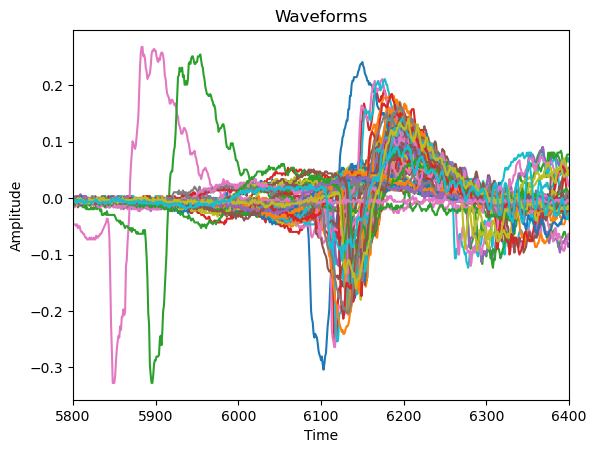

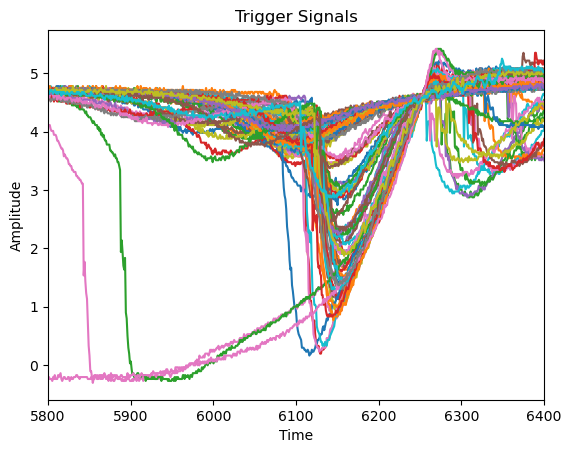

1.3715329273416989e-08 6.066572337868728e-09


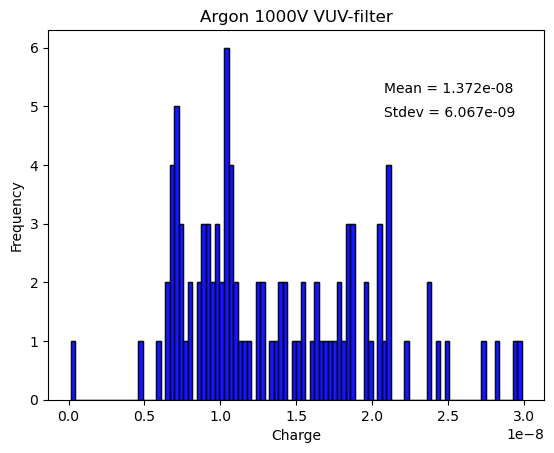

In [8]:
waveforms_55V_1000V_Ar_filter, n_segs_55V_1000V_Ar_filter = read_data("55V_1000V_Ar_filter.csv", 12500)
roi_55V_1000V_Ar_filter = find_roi(waveforms_55V_1000V_Ar_filter, n_segs_55V_1000V_Ar_filter)
areas_55V_1000V_Ar_filter, hist_55V_1000V_Ar_filter, mean_55V_1000V_Ar_filter, stdev_55V_1000V_Ar_filter  = integrate_waveforms(waveforms_55V_1000V_Ar_filter, n_segs_55V_1000V_Ar_filter, roi_55V_1000V_Ar_filter)
hist = plt.hist(areas_55V_1000V_Ar_filter, bins=100, color='blue', edgecolor='black', alpha=0.7)
plt.xlabel("Charge")
plt.ylabel("Frequency")
plt.title("Argon 1000V VUV-filter")
plt.annotate("Mean = {0:3.3e}".format(mean_55V_1000V_Ar_filter), (0.6, 0.75), xycoords='figure fraction')
plt.annotate("Stdev = {0:3.3e}".format(stdev_55V_1000V_Ar_filter), (0.6, 0.7), xycoords='figure fraction')
print(mean_55V_1000V_Ar_filter, stdev_55V_1000V_Ar_filter)

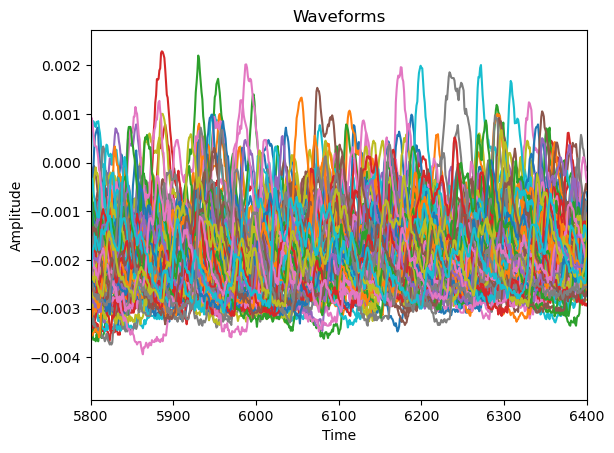

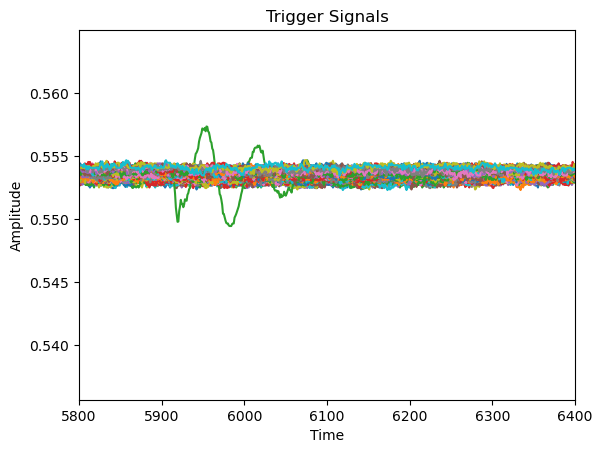

5.453981067761733e-15 5.426642644640274e-14


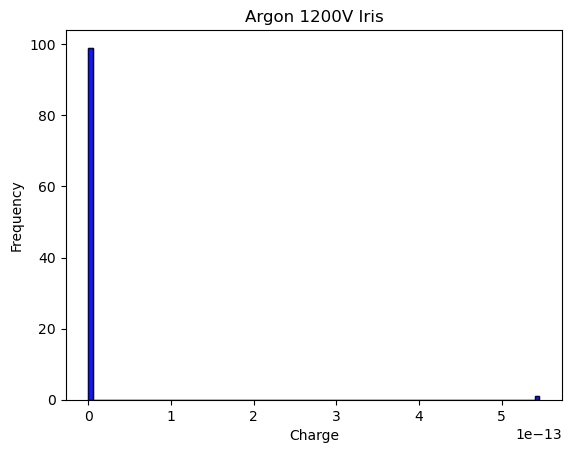

In [9]:
waveforms_55V_1200V_Ar_iris, n_segs_55V_1200V_Ar_iris = read_data("1200V_Ar_VUV_SiPM (06,12,2024).csv", 12500)
roi_55V_1200V_Ar_iris = find_roi(waveforms_55V_1200V_Ar_iris, n_segs_55V_1200V_Ar_iris, plot=False)
areas_55V_1200V_Ar_iris, hist_55V_1200V_Ar_iris, mean_55V_1200V_Ar_iris, stdev_55V_1200V_Ar_iris  = integrate_waveforms(waveforms_55V_1200V_Ar_iris, n_segs_55V_1200V_Ar_iris, roi_55V_1200V_Ar_iris)
hist = plt.hist(areas_55V_1200V_Ar_iris, bins=100, color='blue', edgecolor='black', alpha=0.7)
plt.xlabel("Charge")
plt.ylabel("Frequency")
plt.title("Argon 1200V Iris")
print(mean_55V_1200V_Ar_iris, stdev_55V_1200V_Ar_iris)